# Thermal Transformer Anomaly Detection with Autoencoder
This notebook implements a complete unsupervised anomaly detection pipeline for transformer thermal images using a convolutional autoencoder.
## Outline
1. Import Required Libraries
2. Prepare Dataset (Load, Preprocess, Split)
3. Build and Train Autoencoder Model
4. Visualize Training Results
5. Run Inference on New Images
6. Visualize Anomaly Detection Results (Annotated Image)
7. Save/Load Model and Utility Functions

In [1]:
# Install and import required libraries
%pip install torch torchvision matplotlib pillow --quiet
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from glob import glob


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Analyze Dataset: Count Images, Check Sizes and Color Modes
normal_img_paths = sorted(glob('Sample_Thermal_Images_2/*/normal/*'))
faulty_img_paths = sorted(glob('Sample_Thermal_Images_2/*/faulty/*'))
print(f'Total normal images: {len(normal_img_paths)}')
print(f'Total faulty images: {len(faulty_img_paths)}')

# Check image sizes and color modes
sizes = []
modes = []
for img_path in normal_img_paths[:10] + faulty_img_paths[:10]:  # Sample up to 10 from each
    img = Image.open(img_path)
    sizes.append(img.size)
    modes.append(img.mode)
    print(f'{os.path.basename(img_path)}: size={img.size}, mode={img.mode}')

# Show unique sizes and modes
print('Unique image sizes:', set(sizes))
print('Unique color modes:', set(modes))

Total normal images: 36
Total faulty images: 70
T10_normal_001.jpg: size=(3076, 1916), mode=RGB
T10_normal_002.jpg: size=(3076, 1916), mode=RGB
T10_normal_003.jpg: size=(3076, 1916), mode=RGB
T11_normal_001.jpg: size=(3077, 1920), mode=RGB
T11_normal_002.jpg: size=(3077, 1920), mode=RGB
T11_normal_003.jpg: size=(3077, 1920), mode=RGB
T12_normal_001.jpg: size=(3077, 1920), mode=RGB
T12_normal_002.jpg: size=(3077, 1920), mode=RGB
T12_normal_003.jpg: size=(3077, 1920), mode=RGB
T13_normal_001.jpg: size=(3077, 1920), mode=RGB
T10_faulty_001.jpg: size=(3076, 1916), mode=RGB
T10_faulty_002.jpg: size=(3076, 1916), mode=RGB
T10_faulty_003.jpg: size=(3076, 1916), mode=RGB
T11_faulty_001.jpg: size=(3077, 1920), mode=RGB
T12_faulty_001.jpg: size=(3077, 1920), mode=RGB
T13_faulty_001.jpg: size=(3077, 1920), mode=RGB
T1_faulty_001.jpg: size=(640, 640), mode=RGB
T1_faulty_002.jpg: size=(640, 640), mode=RGB
T1_faulty_003.jpg: size=(640, 640), mode=RGB
T1_faulty_004.jpg: size=(640, 640), mode=RGB
Uniq

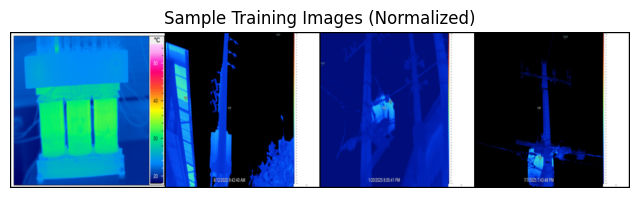

In [3]:
# Custom Dataset for Thermal Images (256x256 RGB)
import torchvision
class ThermalImageDataset(Dataset):
    def __init__(self, img_paths, transform=None):
        self.img_paths = img_paths
        self.transform = transform
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path)
        # Convert RGBA to RGB if needed
        if img.mode == 'RGBA':
            img = img.convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img
    
# Define transforms: resize, to tensor, normalize
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # scale to [-1, 1]
])
    
# Example usage: create dataset and dataloader for normal images
normal_dataset = ThermalImageDataset(normal_img_paths, transform=transform)
train_loader = DataLoader(normal_dataset, batch_size=4, shuffle=True, num_workers=0)
    
# Visualize a batch of images
batch = next(iter(train_loader))
grid = torchvision.utils.make_grid(batch, nrow=4, normalize=True)
plt.figure(figsize=(8, 4))
plt.title('Sample Training Images (Normalized)')
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

In [4]:
# Simple Convolutional Autoencoder for RGB Thermal Images
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # 256x256 -> 128x128
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # 128x128 -> 64x64
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 64x64 -> 32x32
            nn.ReLU(True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), # 32x32 -> 16x16
            nn.ReLU(True),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), # 16x16 -> 32x32
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), # 32x32 -> 64x64
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # 64x64 -> 128x128
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1), # 128x128 -> 256x256
            nn.Tanh() # Output in [-1, 1]
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate model and print summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvAutoencoder().to(device)
print(model)

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (

Epoch [1/100] Loss: 0.4860
Epoch [2/100] Loss: 0.3251
Epoch [2/100] Loss: 0.3251
Epoch [3/100] Loss: 0.2703
Epoch [3/100] Loss: 0.2703
Epoch [4/100] Loss: 0.2366
Epoch [4/100] Loss: 0.2366
Epoch [5/100] Loss: 0.2075
Epoch [5/100] Loss: 0.2075
Epoch [6/100] Loss: 0.1848
Epoch [6/100] Loss: 0.1848
Epoch [7/100] Loss: 0.1601
Epoch [7/100] Loss: 0.1601
Epoch [8/100] Loss: 0.1417
Epoch [8/100] Loss: 0.1417
Epoch [9/100] Loss: 0.1264
Epoch [9/100] Loss: 0.1264
Epoch [10/100] Loss: 0.1132
Epoch [10/100] Loss: 0.1132
Epoch [11/100] Loss: 0.1038
Epoch [11/100] Loss: 0.1038
Epoch [12/100] Loss: 0.0928
Epoch [12/100] Loss: 0.0928
Epoch [13/100] Loss: 0.0834
Epoch [13/100] Loss: 0.0834
Epoch [14/100] Loss: 0.0740
Epoch [14/100] Loss: 0.0740
Epoch [15/100] Loss: 0.0725
Epoch [15/100] Loss: 0.0725
Epoch [16/100] Loss: 0.0731
Epoch [16/100] Loss: 0.0731
Epoch [17/100] Loss: 0.0736
Epoch [17/100] Loss: 0.0736
Epoch [18/100] Loss: 0.0699
Epoch [18/100] Loss: 0.0699
Epoch [19/100] Loss: 0.0666
Epoch [19

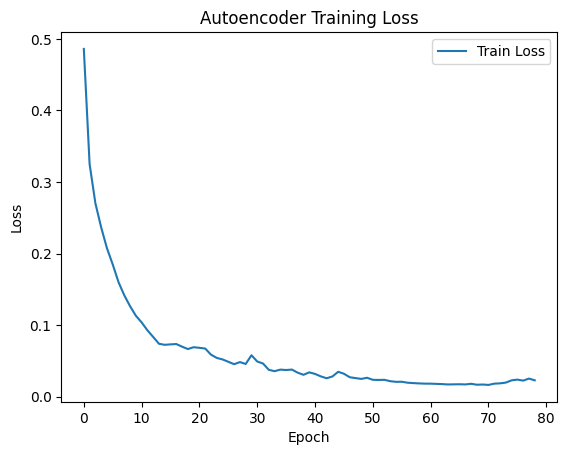

In [5]:
# Training Loop for Autoencoder (100 epochs, batch size 4, early stopping)
num_epochs = 100
batch_size = 4
learning_rate = 1e-2
patience = 8  # Early stopping patience
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
best_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for imgs in train_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f}')
    # Early stopping
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_autoencoder.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print('Early stopping triggered.')
            break

# Plot training loss curve
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Autoencoder Training Loss')
plt.legend()
plt.show()

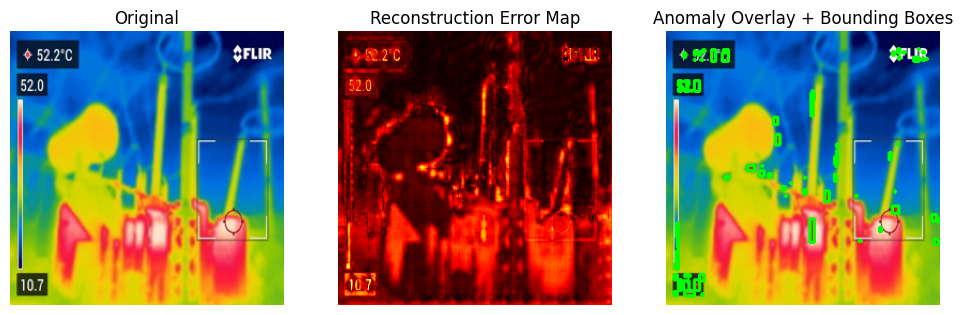

In [8]:
# Inference: Anomaly Detection and Visualization
def load_and_preprocess(img_path):
    img = Image.open(img_path)
    if img.mode == 'RGBA':
        img = img.convert('RGB')
    img = transform(img)
    return img.unsqueeze(0)  # Add batch dimension

def robust_load_rgb(img_path):
    img = Image.open(img_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize((256,256))
    return np.array(img)

# Load best model
model.load_state_dict(torch.load('best_autoencoder.pth', map_location=device))
model.eval()

test_img_path = faulty_img_paths[10]  # Change index for other images
test_img = load_and_preprocess(test_img_path).to(device)

with torch.no_grad():
    recon_img = model(test_img)

error_map = torch.abs(test_img - recon_img).squeeze().cpu().numpy()
if error_map.shape[0] == 3:
    error_map_gray = np.mean(error_map, axis=0)
else:
    error_map_gray = error_map  # fallback for single-channel
threshold = np.percentile(error_map_gray, 99)
anomaly_mask = (error_map_gray > threshold).astype(np.uint8)

orig_img = robust_load_rgb(test_img_path)
overlay = orig_img.copy()

# Mark anomalies in red (RGB only, robust to shape)
if overlay.shape[2] == 3 and anomaly_mask.shape == overlay.shape[:2]:
    overlay[anomaly_mask == 1] = [255, 0, 0]
else:
    # fallback: loop over mask
    for y in range(anomaly_mask.shape[0]):
        for x in range(anomaly_mask.shape[1]):
            if anomaly_mask[y, x] == 1:
                overlay[y, x, :3] = [255, 0, 0]

# Find bounding boxes using OpenCV
import cv2
contours, _ = cv2.findContours(anomaly_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(overlay, (x, y), (x+w, y+h), (0,255,0), 2)  # Green bounding box

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title('Original')
plt.imshow(orig_img); plt.axis('off')
plt.subplot(1,3,2); plt.title('Reconstruction Error Map')
plt.imshow(error_map_gray, cmap='hot'); plt.axis('off')
plt.subplot(1,3,3); plt.title('Anomaly Overlay + Bounding Boxes')
plt.imshow(overlay); plt.axis('off')
plt.show()